# MercariPricePrediction_KaggleChallenge

In [ ]:
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import median_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import hstack
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

## Data Preprocessing

### Data Loading

In [ ]:
#df=pd.read_table('D:\workshop\ML\kaggle\\Mercari\\train.tsv','\t', nrows = 50000)
#df_test=pd.read_table('D:\workshop\ML\kaggle\\Mercari\\test.tsv','\t', nrows = 100000)
df = pd.read_csv('D:\workshop\ML\kaggle\Mercari\minitrain.csv')
print("train data loaded")
df.head(5)

### finding if null

print(df.apply(lambda x: sum(x.isnull()), axis=0))

### functions for text feature extraction
### Encoding

In [14]:
#function to create a word vector for item description
def word_vector(description):
    ps = SnowballStemmer('english')
    s = set(stopwords.words('english'))
    x = []
    for i in range(description.shape[0]):
        comment = re.sub('[^a-zA-Z]', ' ', description[i])
        comment = comment.lower().split()
        comment = [ps.stem(word) for word in comment if word not in s]
        comment = ' '.join(comment)
        x.append(comment)
    word_vector = TfidfVectorizer(smooth_idf=True, sublinear_tf=True, max_df=.5,max_features=2000)
    des_word_features = word_vector.fit_transform(x)
    des_array = des_word_features.toarray()
    itemDesMatrix = pd.DataFrame(des_array, columns=word_vector.get_feature_names())
    return itemDesMatrix    

#  Encoding feature values
def featuresEncoder(dataset):
    le = LabelEncoder()
    le.fit((dataset['name']))
    dataset.name=le.transform(dataset['name']).round(0)
    le.fit((dataset['brand_name']))
    dataset.brand_name=le.transform(dataset['brand_name']).round(0)
    le.fit((dataset['general_cat']))
    dataset.general_cat=le.transform(dataset['general_cat']).round(0)
    le.fit((dataset['sub_cat1']))
    dataset.sub_cat1=le.transform(dataset['sub_cat1']).round(0)
    le.fit((dataset['sub_cat2']))
    dataset.sub_cat2=le.transform(dataset['sub_cat2']).round(0)
    scaler = preprocessing.StandardScaler().fit(dataset[['name', 'brand_name', 'general_cat', 'sub_cat1', 'sub_cat2']])
#     scaler.mean_
#     scaler.scale_
    New_scaled =  scaler.transform(dataset[['name', 'brand_name', 'general_cat', 'sub_cat1', 'sub_cat2']]).round(4)
    return New_scaled

#creating a list of Brands from Training data
def brandList(brandCol):
    brands = set()
    for words in brandCol :
        if words not in brands:
            if type(words) is str:
                words = words.lower()
                brands.add(words.lower())
            else:
                continue
    return brands

#function filling missing values in Brand attribute
def fillBrand(dataset,brands):
    dfToWrite = dataset.iterrows()
    for index, row in dfToWrite:
        if row['brand_name'] == 'no brand':
            x = re.sub('[^a-zA-Z]', ' ', row['name']).split()
            for word in x:
                word = word.lower().strip()
                if word in brands:
                    row['brand_name'] = word
                    dataset.set_value(index, 'brand_name', word)
                    break
    return dataset

## Feature Engineering

In [4]:
#----------------Training------------------------------

# splitting category column into three sub categories
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
df['general_cat'], df['sub_cat1'], df['sub_cat2']= zip(*df['category_name'].apply(lambda x: split_cat(x)))
df=df.drop('category_name', axis=1)
df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL target,3,NaN,10,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues nike,1,NaN,35,1,target New with tags. Leather horses. Retail f...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


## exploratory data analysis

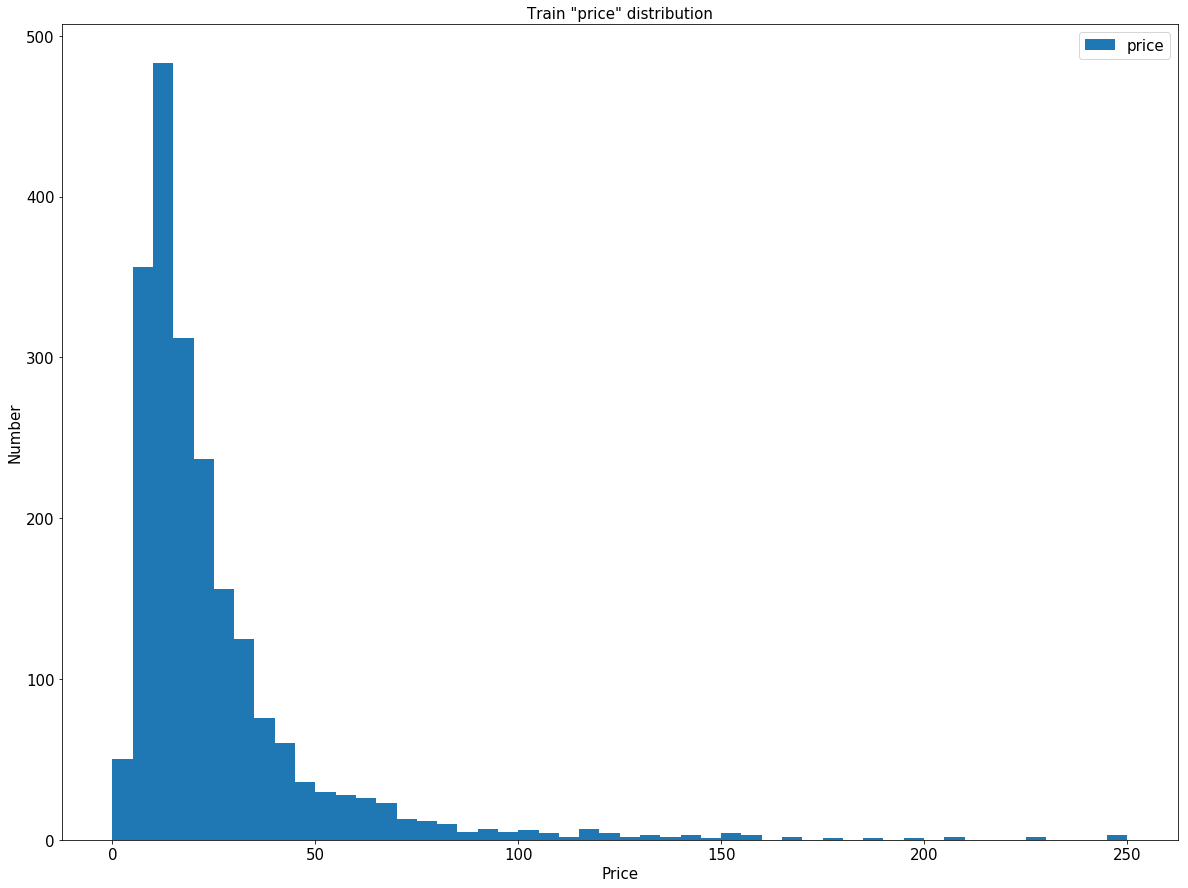

In [5]:
import matplotlib.pyplot as plt
# Price distribution
plt.figure(figsize=(20, 15))
plt.hist(df['price'], bins=50, range=[0,250], label='price')
plt.title('Train "price" distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

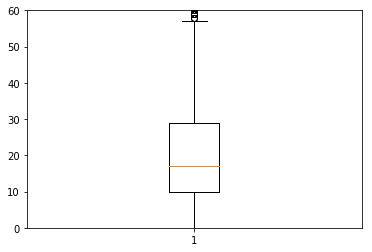

In [6]:
#plt.figure(figsize=(50, 20))
plt.boxplot(df['price'])
plt.ylim(0, 60)
plt.show()

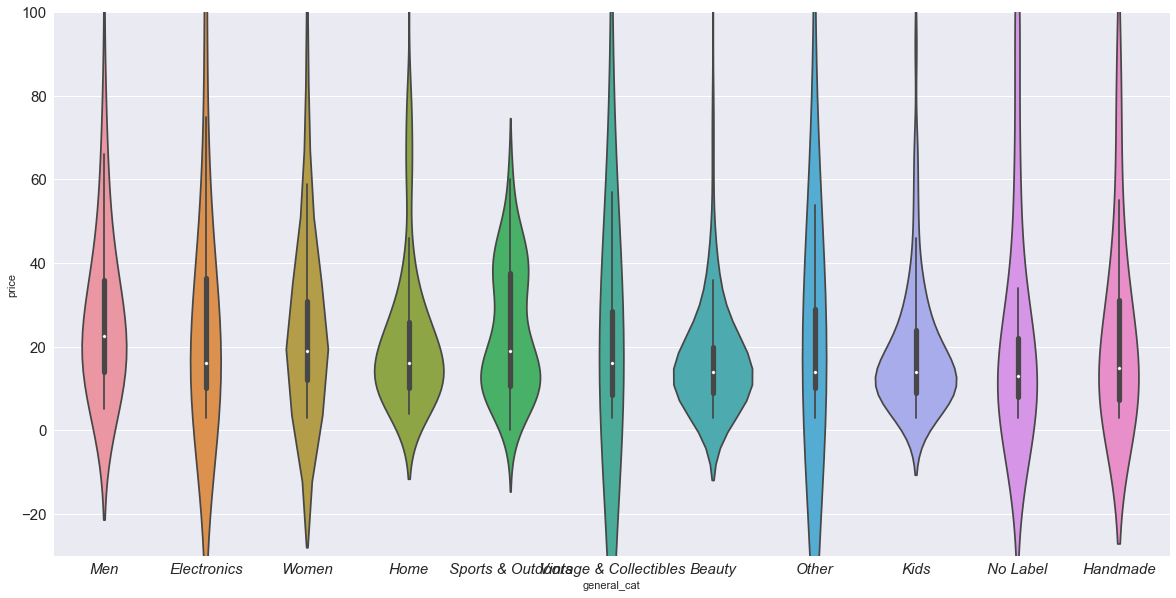

In [7]:
import seaborn as sns
plt.figure(figsize=(20, 10))
sns.violinplot(x='general_cat',y='price',data=df)
plt.ylim(-30, 100)
#plt.xlim(0,13)
plt.xticks(fontsize=15,style='oblique')
plt.yticks(fontsize=15)
plt.show()

In [ ]:
#preparing a list of brands
trainBrands = brandList(df['brand_name'])
trainBrands

In [9]:
# filling missing values
df.brand_name=df.brand_name.fillna('no brand')
df.item_description=df.item_description.fillna('No description yet')
df = fillBrand(df,trainBrands)
df.to_csv("D:\workshop\ML\kaggle\Mercari\df.csv", index=False)
df = pd.read_csv('D:\workshop\ML\kaggle\Mercari\df.csv',encoding = "ISO-8859-1")
df.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL target,3,mlb,10,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues nike,1,nike,35,1,target New with tags. Leather horses. Retail f...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,no brand,44,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [10]:
#finding if null
#df.apply(lambda x: sum(x.isnull()), axis=0)

In [11]:
#Preprocessing training data with text feature extraction, encoding and scaling
trainDesMatrix = word_vector(df['item_description'])
df = df.join(trainDesMatrix, on='price', how='left', rsuffix='_right')
df_train=df.copy()
df_train = df_train.drop('train_id', axis=1)
df_train = df_train.drop('item_description', axis=1)
train_price=df_train.price
df_train = df_train.drop('price', axis=1)
df_train_price=df['price']
df_train = df_train.join(df_train_price)
df_train.head(5)
train_scaled = featuresEncoder(df_train)

X = np.array(df_train.iloc[:, 0:-1].values)
Y = np.array(df_train.iloc[:, -1].values)
del df
del df_train

## Training model

In [12]:
#---------------------------------------Training----------------------------------------------------------------
from sklearn.model_selection import train_test_split
train_sparse_matrix, valid_sparse_matrix, y_train, y_valid = train_test_split(X, Y, test_size=0.05, random_state=144)
d_train = lgb.Dataset(train_sparse_matrix, label=y_train)
#d_valid = lgb.Dataset(valid_sparse_matrix, label=y_valid)
params ={ 'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE'}
classifier = lgb.train( params, train_set=d_train, num_boost_round=3200, verbose_eval=100)
#classifier = LogisticRegression(solver='sag')
# classifier = classifier.fit(train_sparse_matrix,y_train)
predictions= classifier.predict(valid_sparse_matrix)

pred=[]
for prediction in predictions:
    if prediction<0:
        prediction=0
    pred.append(float(prediction))
predNP=np.array(pred)
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))
print(rmsle(y_valid, predNP))

0.9028017532


In [13]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
# gbr = GradientBoostingRegressor(n_estimators=200,learning_rate =0.09,
#                                min_samples_split= 2, max_depth=10,
#                                max_features=20, loss= 'huber')
# gbr = gbr.fit(X_train, Y_train)
# predictions=gbr.predict(X_test)
# pred=[]
# for prediction in predictions:
#     if prediction<0:
#         prediction=0
#     pred.append(prediction)
# predNP=np.array(pred)
# def rmsle(y, y0):
#     assert len(y) == len(y0)
#     return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))
# print(rmsle(Y_test, predNP))
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
gbr = GradientBoostingRegressor(n_estimators=200,learning_rate =0.09,
                               min_samples_split= 2, max_depth=10,
                               max_features=20, loss= 'huber')
#gbr = LogisticRegression(solver='sag')
gbr = gbr.fit(X_train, Y_train)
predictions=gbr.predict(X_test)
predInt=[]
for prediction in predictions:
    if prediction<0:
        prediction=0
    predInt.append(int(prediction))
predIntNP=np.array(predInt)
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y0), 2)))
print(rmsle(Y_test, predIntNP))

0.30543454899
